# packages

In [22]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("pandas")
install("numpy")
install("matplotlib")

# imports

In [27]:
import pandas as pd
import numpy as np
import json
import csv
import os
import matplotlib.pyplot as plt
params = {}
destination_folder = 'target/img/'

## Prepare Data for 3D charts

In [31]:
source_target_mde_domain = pd.DataFrame(columns = ['source', 'target', 'mde', 'domain'])
target_categories = pd.DataFrame(columns = ['cat'])
main_categories = pd.DataFrame(columns = ['source'])
twin_system_lcp = pd.DataFrame(columns = ['tlcp', 'slcp'])


with open("./target/json/data_consolidated_semistructured__4.json", 'r') as json_file:
    data_semistr = json.load(json_file)
    
#mde_techniques = data["model processing technique"].value_counts().index.tolist()
for title, contents in data_semistr.items():
    keys = contents.keys()
    if "use case domain" in keys:
        domain = contents["use case domain"]
    else:
        domain = "N/A"
    trl = contents["Technological Readiness Level"]
    twinning_target = contents["twinning target"]
    tlcp = contents["twin lifecycle phase"]
    for index, mdeContents in contents["modelTrafos"].items():
        mdeContents = json.loads(mdeContents)
        src_cat_1 = mdeContents["source category"]
        src_cat_2 = mdeContents["source sub-category 1"]
        src_cat_2_1 = mdeContents["source sub-category 2"]
        src_cat_3 = mdeContents["source model target category"]
        trg_cat_1 = mdeContents["target category"]
        trg_cat_1_1 = mdeContents["target category 2"]
        trg_cat_2 = mdeContents["target sub-category 1"]
        trg_cat_2_1 = mdeContents["target sub-category 2"]
        slcp = mdeContents["system lifecycle phase"]
        trg_cat_3 = mdeContents["target model target category"]
        mde_technique = mdeContents["model processing technique"]
        new_line = pd.DataFrame([{"source": src_cat_2, "target": trg_cat_2, "mde": mde_technique, "domain": domain}])
        source_target_mde_domain = pd.concat([source_target_mde_domain, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"source": src_cat_2, "target": trg_cat_2_1, "mde": mde_technique, "domain": domain}])
        source_target_mde_domain = pd.concat([source_target_mde_domain, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"source": src_cat_2_1, "target": trg_cat_2, "mde": mde_technique, "domain": domain}])
        source_target_mde_domain = pd.concat([source_target_mde_domain, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"source": src_cat_2_1, "target": trg_cat_2_1, "mde": mde_technique, "domain": domain}])
        source_target_mde_domain = pd.concat([source_target_mde_domain, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"cat": src_cat_3}])
        target_categories = pd.concat([target_categories, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"cat": trg_cat_3}])
        target_categories = pd.concat([target_categories, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"cat": src_cat_1}])
        main_categories = pd.concat([main_categories, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"cat": trg_cat_1}])
        main_categories = pd.concat([main_categories, new_line], ignore_index=True)
        #new_line = pd.DataFrame([{"cat": trg_cat_1_1}])
        #main_categories = pd.concat([main_categories, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"tlcp": tlcp, "slcp": slcp}])
        twin_system_lcp = pd.concat([twin_system_lcp, new_line], ignore_index=True)

source_target_mde = source_target_mde_domain.drop("domain", axis=1)
source_target_mtom = source_target_mde[source_target_mde['mde'] == "Model to Model Transformation"]  
source_target_mtom = source_target_mtom.drop("mde", axis=1)
source_target_mtom = source_target_mtom.dropna()
source_target_mtom = source_target_mtom.groupby(["source", "target"]).size().unstack()
source_target_mtom = source_target_mtom.fillna(0).astype(int)
source_target_mtom.to_csv("./data/categorization_modeltomodel.csv", sep=";", index=True)

source_target_mi = source_target_mde[source_target_mde['mde'] == "Model Interpretation"]  
source_target_mi = source_target_mi.dropna()
source_target_mi = source_target_mi.groupby(["source", "target"]).size().unstack()
source_target_mi = source_target_mi.fillna(0).astype(int)
source_target_mi.to_csv("./data/categorization_modelinterpretation.csv", sep=";", index=True)

source_target_mtot = source_target_mde[source_target_mde['mde'] == "Code Generation"]  
source_target_mtot = source_target_mtot.dropna()
source_target_mtot = source_target_mtot.groupby(["source", "target"]).size().unstack()
source_target_mtot = source_target_mtot.fillna(0).astype(int)
source_target_mtot.to_csv("./data/categorization_modeltotext.csv", sep=";", index=True)

twin_system_lcp = twin_system_lcp[twin_system_lcp["slcp"].isin(["Design", "Implement", "Operate"])]
twin_system_lcp = twin_system_lcp[twin_system_lcp["tlcp"].isin(["As-Designed", "As-Operated"])]
twin_system_lcp = twin_system_lcp.groupby(["tlcp", "slcp"]).size().unstack()
twin_system_lcp = twin_system_lcp.fillna(0).astype(int)
twin_system_lcp.to_csv("./data/twin_system_lcp.csv", sep=";")

source_target_mde_domain = source_target_mde_domain[source_target_mde_domain["domain"].isin(["Manufacturing", "Accommodation", "Transportation and Storage", "Electricity"])]

# Experimental
model_categories = ["data model","state-based behavior", "ui configuration model", "architecture model", "continuous behavior", "ontology"]
software_categories = ["runtime data", "other software code", "visualization software", "machine learning model", "simulation code"]
source_model = source_target_mde_domain[source_target_mde_domain['source'].isin(model_categories)] 
target_model = source_target_mde_domain[source_target_mde_domain['target'].isin(model_categories)] 
models = source_model.append(target_model, ignore_index=True)
generation_target = source_target_mde_domain[source_target_mde_domain['target'] == "Code Generation"] 
generation_target = generation_target[generation_target['target'].isin(software_categories)]
generation_target = generation_target.groupby(["target", "domain"]).size().unstack()
interpretation_engines = source_target_mde_domain[source_target_mde_domain['target'] == "Model Interpretation"] 
interpretation_engines = interpretation_engines[interpretation_engines['target'].isin(software_categories)]
interpretation_engines = interpretation_engines.groupby(["target", "domain"]).size().unstack()

models.to_csv("./data/model_artefacts.csv", sep=";", index=True)
generation_target.to_csv("./data/generation_targets.csv", sep=";", index=True)
interpretation_engines.to_csv("./data/interpretation_engines.csv", sep=";", index=True)

C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_9300\4030037068.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = source_model.append(target_model, ignore_index=True)


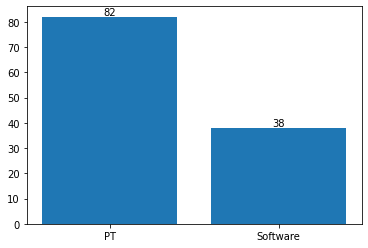

cat
Software                      62
behavior + structure model    13
behavior model                39
structural model              71
dtype: int64


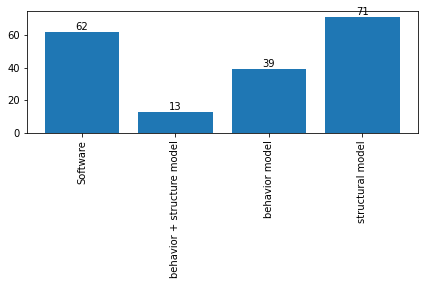

In [42]:
target_categories_grouped = target_categories.groupby("cat").size()
fix, ax = plt.subplots()
container = plt.bar(["PT", "Software"], [target_categories_grouped.iloc[0], target_categories_grouped[2]])
ax.bar_label(container)
plt.savefig(destination_folder + "model_categories_target_bar.jpg")
plt.show()
main_categories = main_categories[main_categories["cat"] != "software"]
main_categories_grouped = main_categories.groupby("cat")
main_categories_size = main_categories_grouped.size()
print(main_categories_size)
row_names = []
height_values = []
for index, value in main_categories_grouped:
    row_names.append(index)
    height_values.append(main_categories_size[index])
fix, ax = plt.subplots()
container = plt.bar(row_names, height_values)
ax.bar_label(container)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(destination_folder + "model_categories_main_bar.jpg")

In [21]:


def scatter(y_value, column_name, df, x, x_values):
    y_plot = [y_value] * (len(x_values))
    labels =  df[column_name]
    plt.scatter(x, y_plot, labels*2500)
    for i, txt in enumerate(labels):
        if(txt != 0):
            plt.annotate(txt, (x[i], y_plot[i]), fontsize=30, ha='center', va='center')


def scatter_for_df(df):
    x_values = list(df.index)
    y_values = list(df.columns)

    x = [i * 1 for i in range(1, len(x_values)+1)]
    y = range(1,len(y_values)+1)

    
    for idx in y:
        scatter(idx, y_values[idx-1], df, x, x_values)

    plt.xticks(ticks=x, labels=x_values, rotation=90, fontsize=30)
    plt.yticks(ticks=y, labels=y_values, fontsize=30)
    plt.grid()

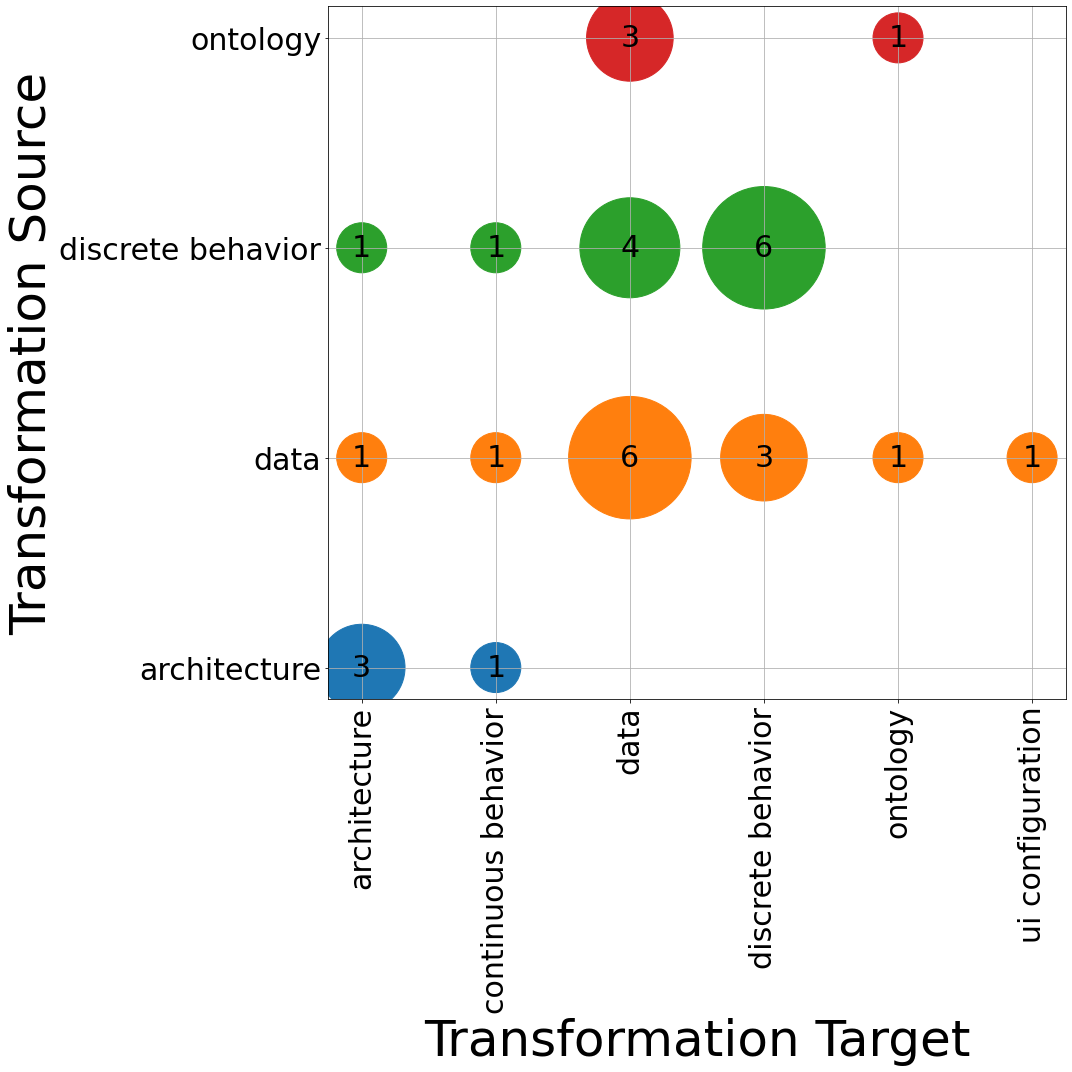

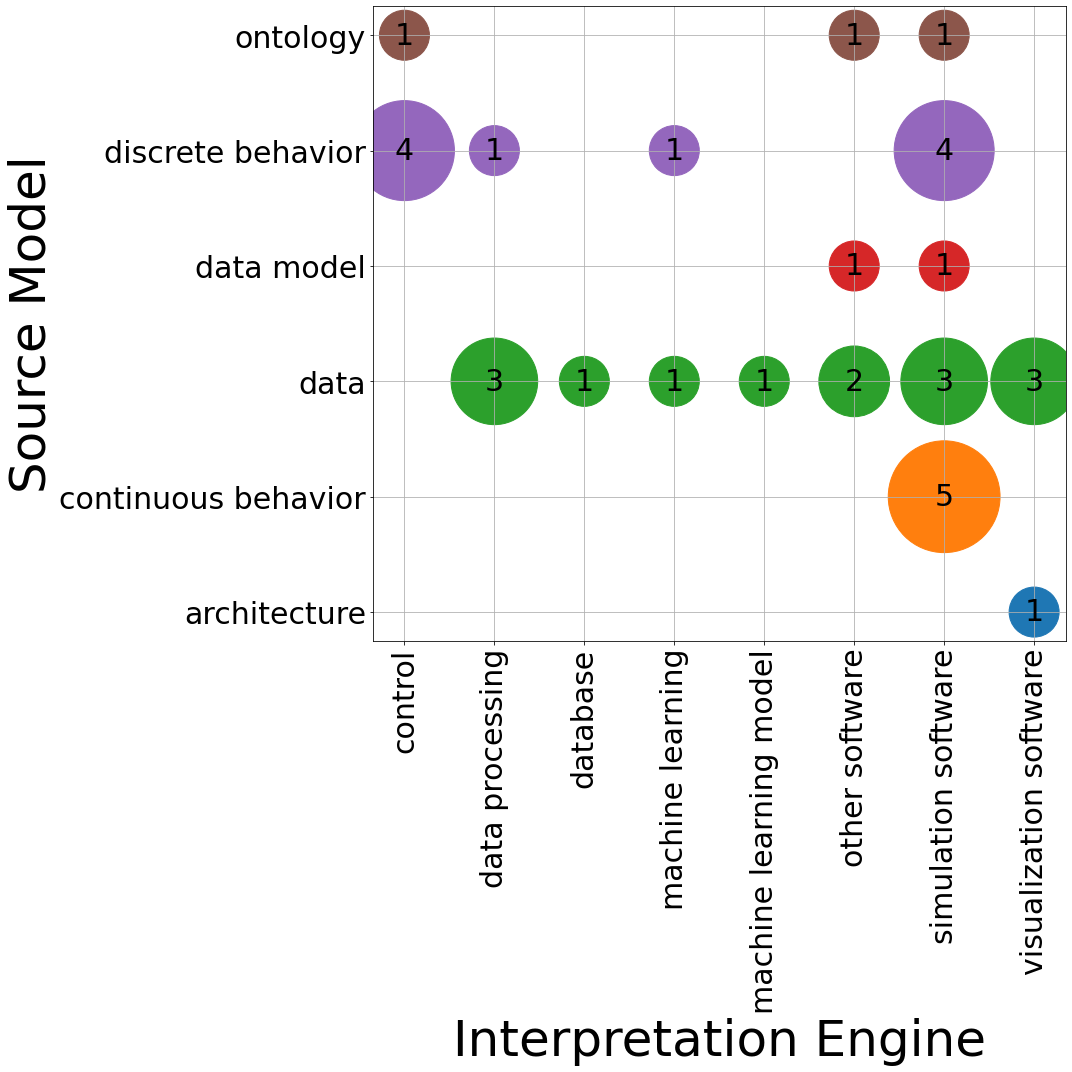

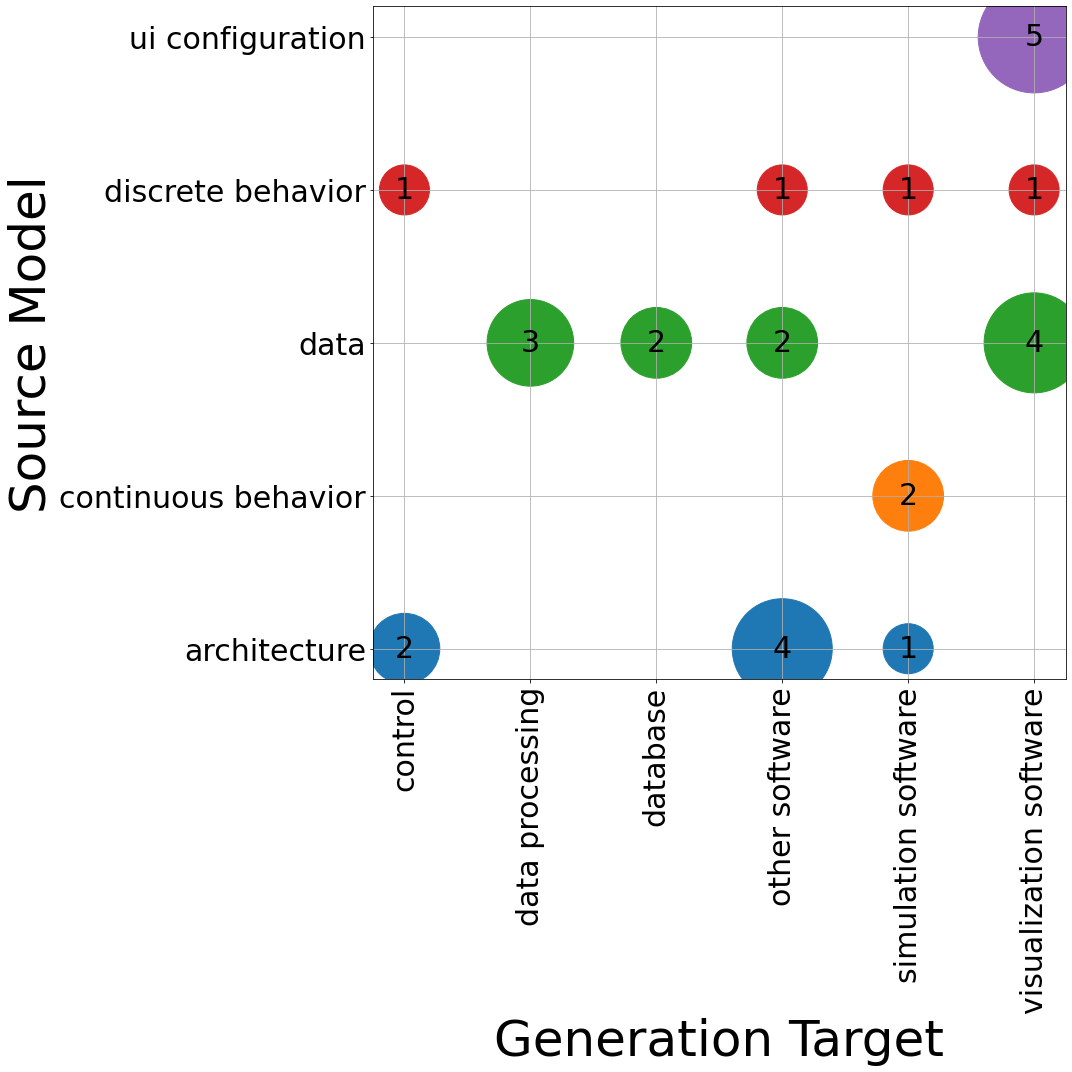

In [43]:
source_target = pd.read_csv("./data/categorization_modeltomodel.csv", sep=";", header=0, index_col = 0)
source_target = source_target.transpose()
plt.figure(figsize=(15,15))
size_multiplier = 2500
scatter_for_df(source_target)
plt.xlabel("Transformation Target", fontsize=50)
plt.ylabel("Transformation Source", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "mde_modeltomodel_scatter.jpg")

source_target = pd.read_csv("./data/categorization_modelinterpretation.csv", sep=";", header=0, index_col = 0)
source_target = source_target.transpose()
plt.figure(figsize=(15,15))
size_multiplier = 2500
scatter_for_df(source_target)
plt.xlabel("Interpretation Engine", fontsize=50)
plt.ylabel("Source Model", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "mde_modelinterpretation_scatter.jpg")

source_target = pd.read_csv("./data/categorization_modeltotext.csv", sep=";", header=0, index_col = 0)
source_target = source_target.transpose()
plt.figure(figsize=(15,15))
size_multiplier = 2500
scatter_for_df(source_target)
plt.xlabel("Generation Target", fontsize=50)
plt.ylabel("Source Model", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "mde_modeltotext_scatter.jpg")



<Figure size 1080x1080 with 0 Axes>

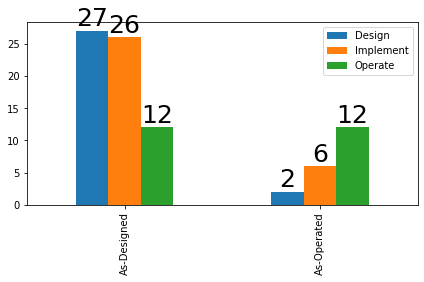

In [44]:
source_target = pd.read_csv("./data/twin_system_lcp.csv", sep=";", header=0, index_col = 0)
#source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
ax = source_target.plot(kind="bar", stacked=False)
for container in ax.containers:
    ax.bar_label(container, fontsize=25)
plt.xlabel("")
plt.tight_layout()
plt.savefig(destination_folder + "slcp_tlcp_barchart.jpg")

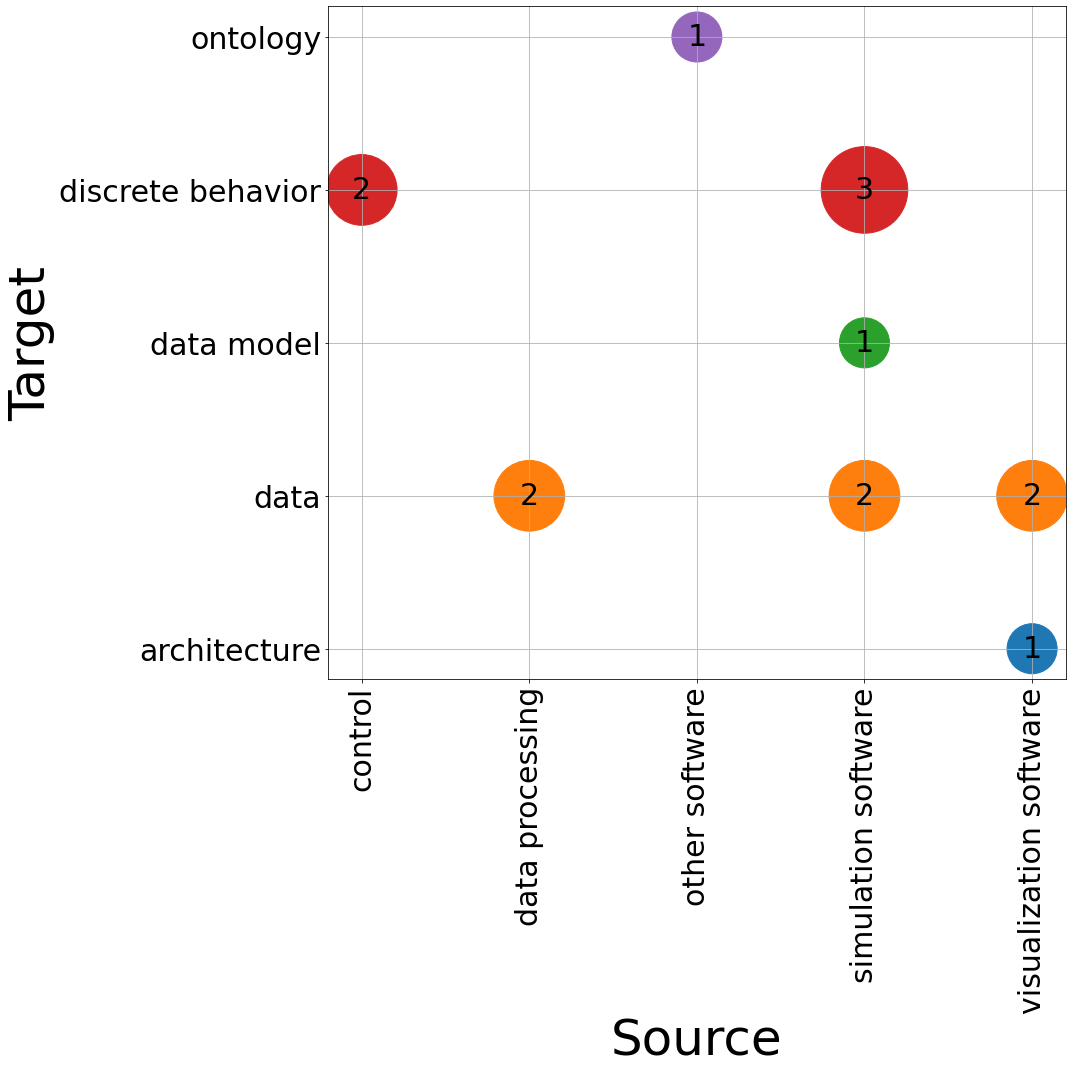

In [48]:
source_target_mde_domain_manufacturing = source_target_mde_domain[source_target_mde_domain["domain"] == "Manufacturing"]
source_target_mde_domain_manufacturing_mi = source_target_mde_domain_manufacturing[source_target_mde_domain_manufacturing["mde"] == "Model Interpretation"]
source_target = source_target_mde_domain_manufacturing_mi.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_manufacturing_modelinterpretation.jpg")

source_target_mde_domain_manufacturing_mtom = source_target_mde_domain_manufacturing[source_target_mde_domain_manufacturing["mde"] == "Model to Model Transformation"]
source_target = source_target_mde_domain_manufacturing_mtom.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_manufacturing_modeltomodel.jpg")

source_target_mde_domain_manufacturing_mtot = source_target_mde_domain_manufacturing[source_target_mde_domain_manufacturing["mde"] == "Code Generation"]
source_target = source_target_mde_domain_manufacturing_mtot.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_manufacturing_modeltotext.jpg")

source_target_mde_domain_transportation = source_target_mde_domain[source_target_mde_domain["domain"] == "Transportation and Storage"]
source_target_mde_domain_manufacturing_mi = source_target_mde_domain_transportation[source_target_mde_domain_transportation["mde"] == "Model Interpretation"]
source_target = source_target_mde_domain_manufacturing_mi.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_transportation_modelinterpretation.jpg")

source_target_mde_domain_transportation_mtom = source_target_mde_domain_transportation[source_target_mde_domain_transportation["mde"] == "Model to Model Transformation"]
source_target = source_target_mde_domain_transportation_mtom.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_transportation_modeltomodel.jpg")

source_target_mde_domain_transportation_mtot = source_target_mde_domain_transportation[source_target_mde_domain_transportation["mde"] == "Code Generation"]
source_target = source_target_mde_domain_transportation_mtot.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_transportation_modeltotext.jpg")

#.isin(["Manufacturing", "Accommodation", "Transportation and Storage", "Electricity"])]


source_target_mde_domain_accommodation = source_target_mde_domain[source_target_mde_domain["domain"] == "Accommodation"]
source_target_mde_domain_accomodation_mi = source_target_mde_domain_accommodation[source_target_mde_domain_accommodation["mde"] == "Model Interpretation"]
source_target = source_target_mde_domain_accomodation_mi.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_accommodation_modelinterpretation.jpg")

source_target_mde_domain_accomodation_mtom = source_target_mde_domain_accommodation[source_target_mde_domain_accommodation["mde"] == "Model to Model Transformation"]
source_target = source_target_mde_domain_accomodation_mtom.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_accommodation_modeltomodel.jpg")

source_target_mde_domain_accomodation_mtot = source_target_mde_domain_accommodation[source_target_mde_domain_accommodation["mde"] == "Code Generation"]
source_target = source_target_mde_domain_accomodation_mtot.groupby(["source", "target"]).size().unstack()
source_target = source_target.fillna(0).astype(int)
source_target = source_target.transpose()
plt.figure(figsize=(15, 15))
scatter_for_df(source_target)
plt.xlabel("Source", fontsize=50)
plt.ylabel("Target", fontsize=50)
plt.tight_layout()
plt.savefig(destination_folder + "domain_source_target_accommodation_modeltotext.jpg")

#.isin(["Manufacturing", "Accommodation", "Transportation and Storage", "Electricity"])]


#.isin(["Manufacturing", "Accommodation", "Transportation and Storage", "Electricity"])]


## What

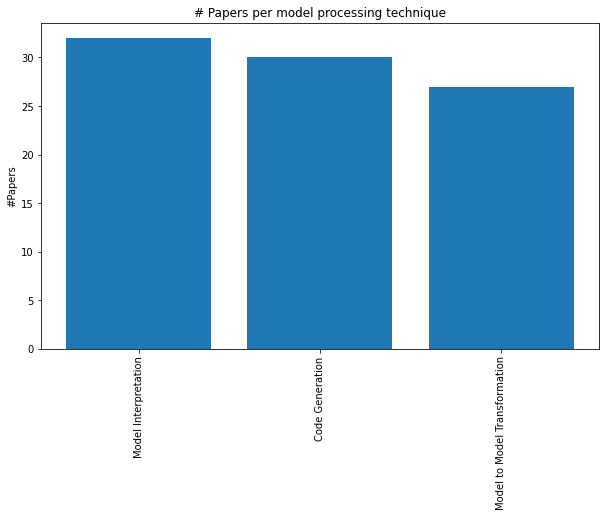

In [40]:
occurrences_df = data["model processing technique"].value_counts().reset_index()
occurrences_df.columns = ['entry', 'count']
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(occurrences_df['entry'], occurrences_df['count'])
plt.ylabel('#Papers')
plt.title('# Papers per model processing technique')
plt.xticks(rotation=90)  # Rotate the x-axis labels if they are too long
plt.show()

In [47]:
data["modeling language"].value_counts()

UML Class Diagram                        4
AutomationML                             3
MontiArc                                 3
SysML                                    2
SysML v2                                 2
BPMN                                     2
Unity 3D simulation model                2
AAS                                      2
MontiGem GUI Model                       1
City GML 3D city model                   1
design of experiment language            1
OPC UA DSL                               1
Tagging Language                         1
MontiArc ADL                             1
tagging language                         1
MontiThings                              1
GUI DSL                                  1
OCL                                      1
cyber-physical spaces                    1
UML Activity Diagram                     1
undefined                                1
Twin Process Model                       1
EMF Meta-Models                          1
Data Model 

C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_dat

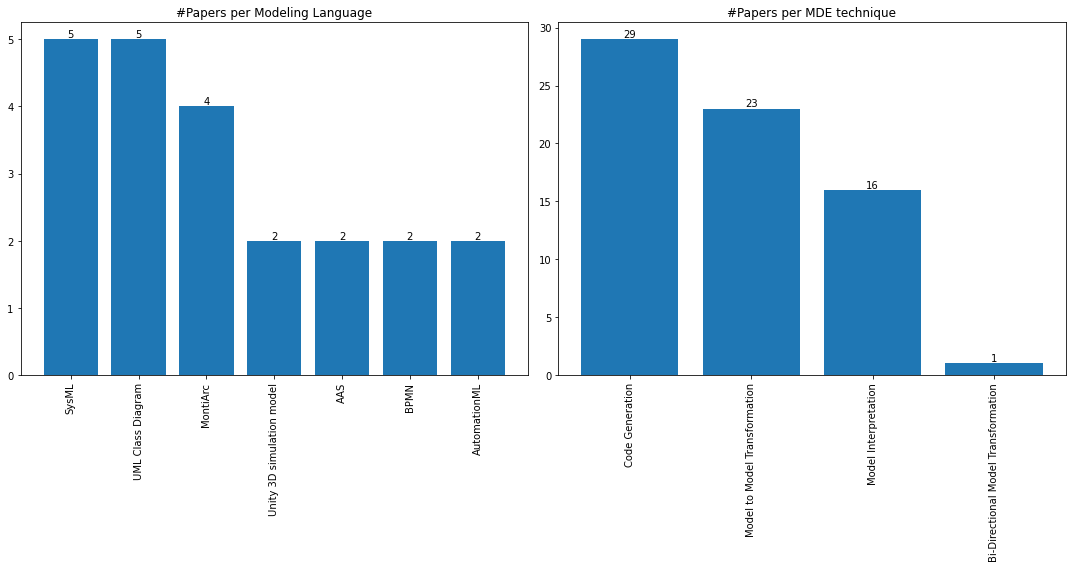

c:\Users\Daniel Lehner\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


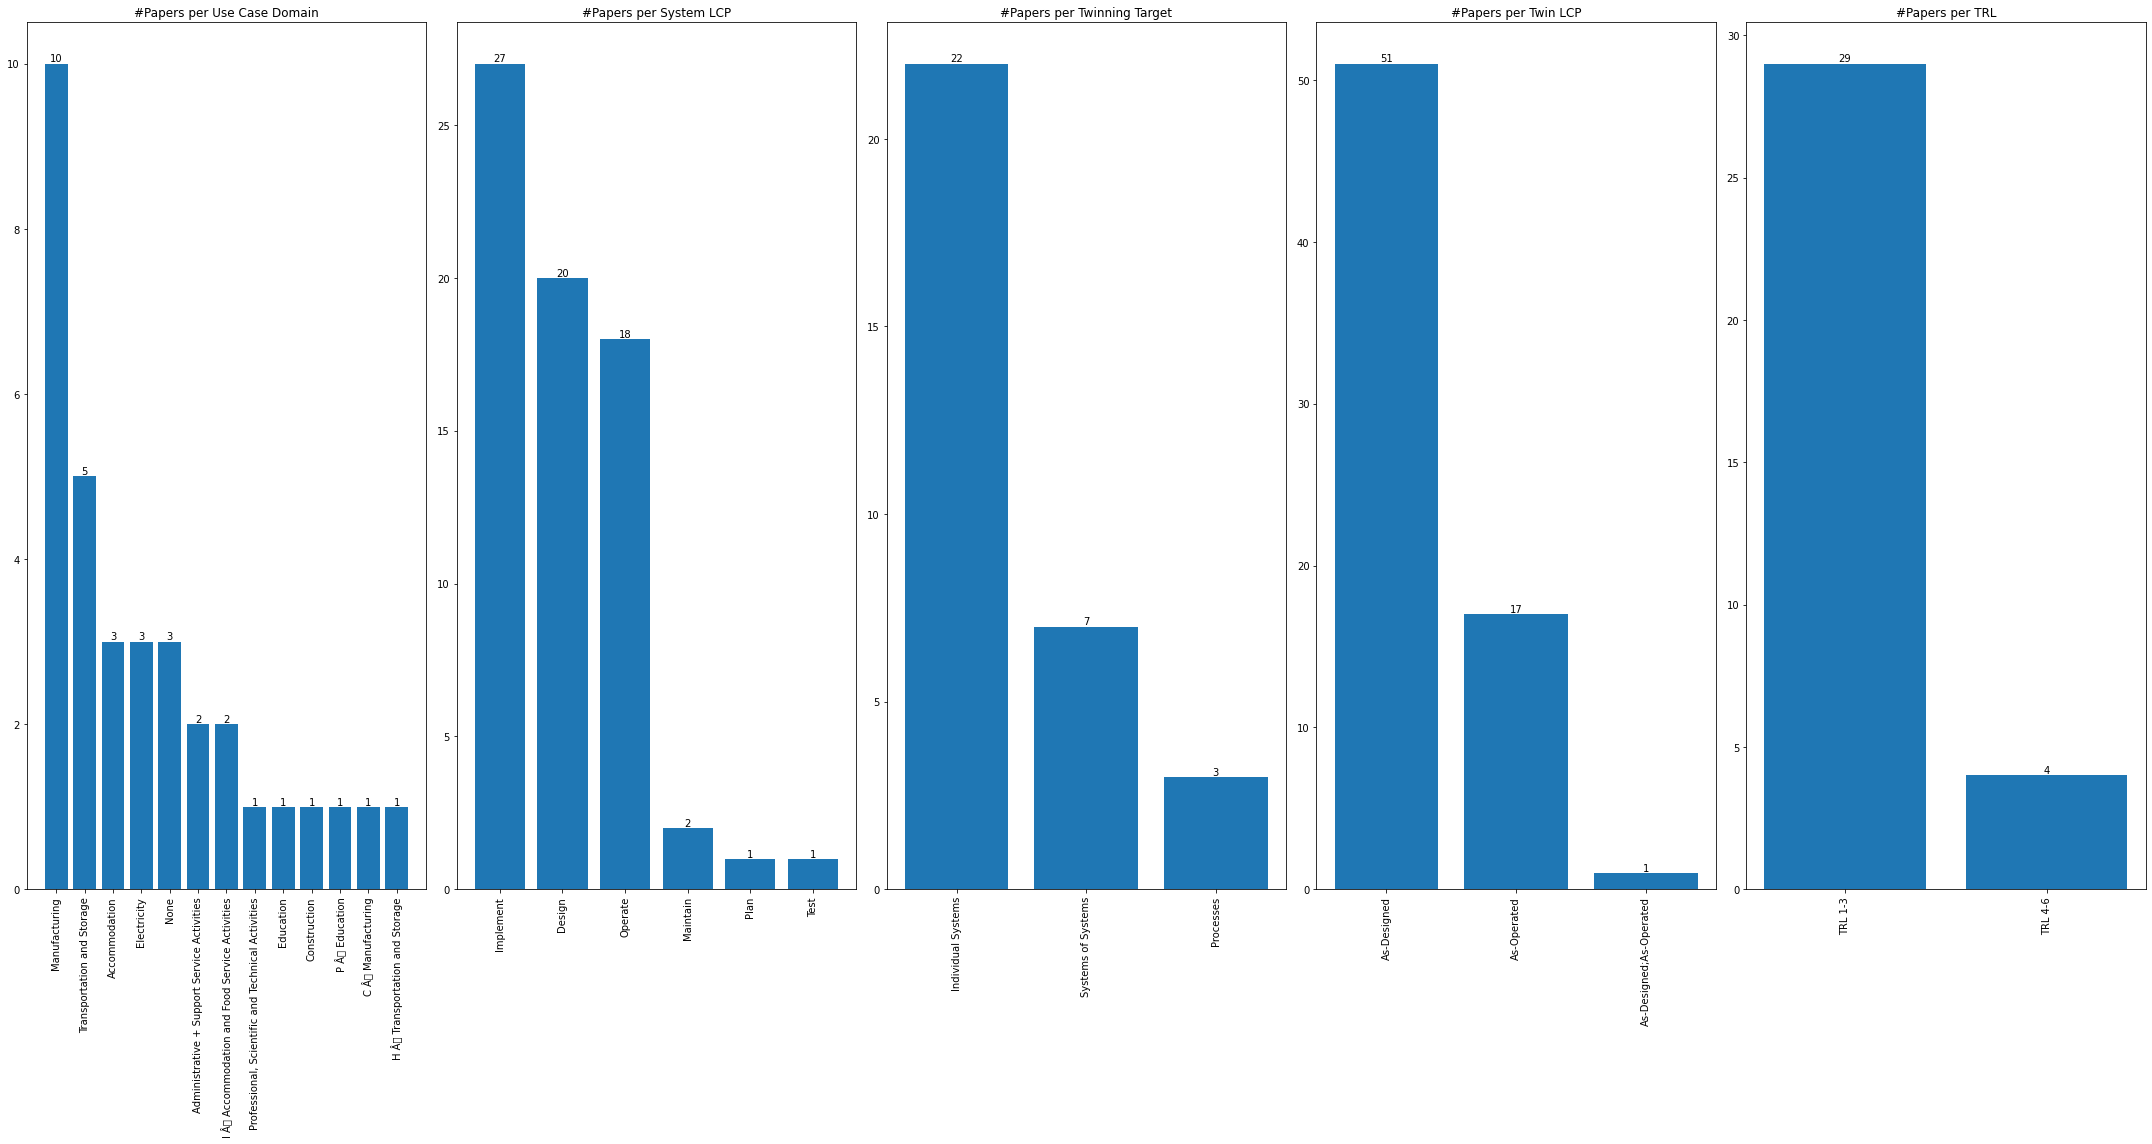

In [4]:
modeling_language = data["modeling language"].value_counts().reset_index()
modeling_language.columns = ['entry', 'count']
modeling_language  = modeling_language[modeling_language['count'] > 1]
mde_technique= data["model processing technique"].value_counts().reset_index()
mde_technique.columns = ['entry', 'count']
use_case_domain = data["use case domain"].value_counts().reset_index()
use_case_domain.columns = ['entry', 'count']
system_lcp = data["system lifecycle phase"].value_counts().reset_index()
system_lcp.columns = ['entry', 'count']
twinning_target = data["twinning target"].value_counts().reset_index()
twinning_target.columns = ['entry', 'count']
twin_lcp= data["twin lifecycle phase"].value_counts().reset_index()
twin_lcp.columns = ['entry', 'count']
trl = data["Technological Readiness Level"].value_counts().reset_index()
trl.columns = ['entry', 'count']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# List of DataFrames
dataframes = [modeling_language, mde_technique]
# Titles for each subplot (modify as needed)
titles = ['#Papers per Modeling Language', '#Papers per MDE technique']

# Loop through the subplots and plot each bar chart
for i, ax in enumerate(axes.flatten()):
    if i < len(dataframes):
        plot_data = dataframes[i]
        ax.bar(plot_data['entry'], plot_data['count'], tick_label=plot_data['count'])  # Replace 'x' and 'y' with the appropriate column names from the DataFrame
        ax.set_title(titles[i])
        ax.set_xticklabels(plot_data['entry'], rotation=90)
        ax.bar_label(ax.containers[0])

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
#plt.show()
plt.savefig("what.jpg")

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 16))

# List of DataFrames
dataframes = [use_case_domain, system_lcp, twinning_target, twin_lcp, trl]
# Titles for each subplot (modify as needed)
titles = ['#Papers per Use Case Domain', '#Papers per System LCP', '#Papers per Twinning Target', '#Papers per Twin LCP', '#Papers per TRL']

# Loop through the subplots and plot each bar chart
for i, ax in enumerate(axes.flatten()):
    if i < len(dataframes):
        plot_data = dataframes[i]
        ax.bar(plot_data['entry'], plot_data['count'])  # Replace 'x' and 'y' with the appropriate column names from the DataFrame
        ax.set_title(titles[i])
        ax.set_xticklabels(plot_data['entry'], rotation=90)
        ax.bar_label(ax.containers[0])

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.savefig("where.jpg")

{'A framework for Model-Driven Engineering of resilient software-controlled systems': {'DT_Definition': 'dynamic virtual model of a system, processor, or service, with data (e.g., sensor data) from physical systems or processes integrated into it.; "Software digital twins representations provide a key abstraction, providing an agile interface on hardware components, capturing operational behaviours of physical assets and processes, also providing refined and interpreted data, to enable diagnoses, predic\x02tive maintenance tasks, process plannings, process optimizations, virtual prototyping, and simulation."', 'modelTrafos': {'0': '{"model type":"structure","model processing technique":"Model to Model Transformation","model usage technique":null,"source":"SysML: BDD","target":"Knowledge Base of software digital twins (Metamodel proposed in Figure 5 of the paper) -> in fact, this is the class diagram of their knowledge base","purpose of MDE application":"reuse information created by rel

## Where

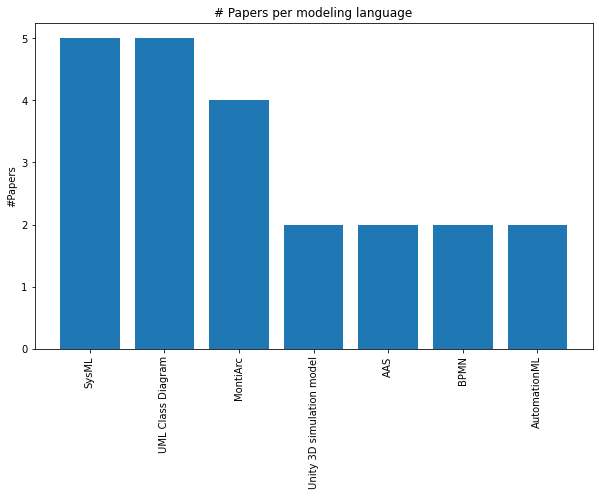

In [5]:
occurrences_df = data["modeling language"].value_counts().reset_index()
occurrences_df.columns = ['entry', 'count']
occurrences_df = occurrences_df[occurrences_df['count'] > 1]
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(occurrences_df['entry'], occurrences_df['count'])
plt.ylabel('#Papers')
plt.title('# Papers per modeling language')
plt.xticks(rotation=90)  # Rotate the x-axis labels if they are too long
plt.show()

C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_18300\3757160740.py:40: UserWarning: Glyph 151 (\x97) missing from current font.
  plt.savefig("where_detailed.jpg")
c:\Users\Daniel Lehner\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


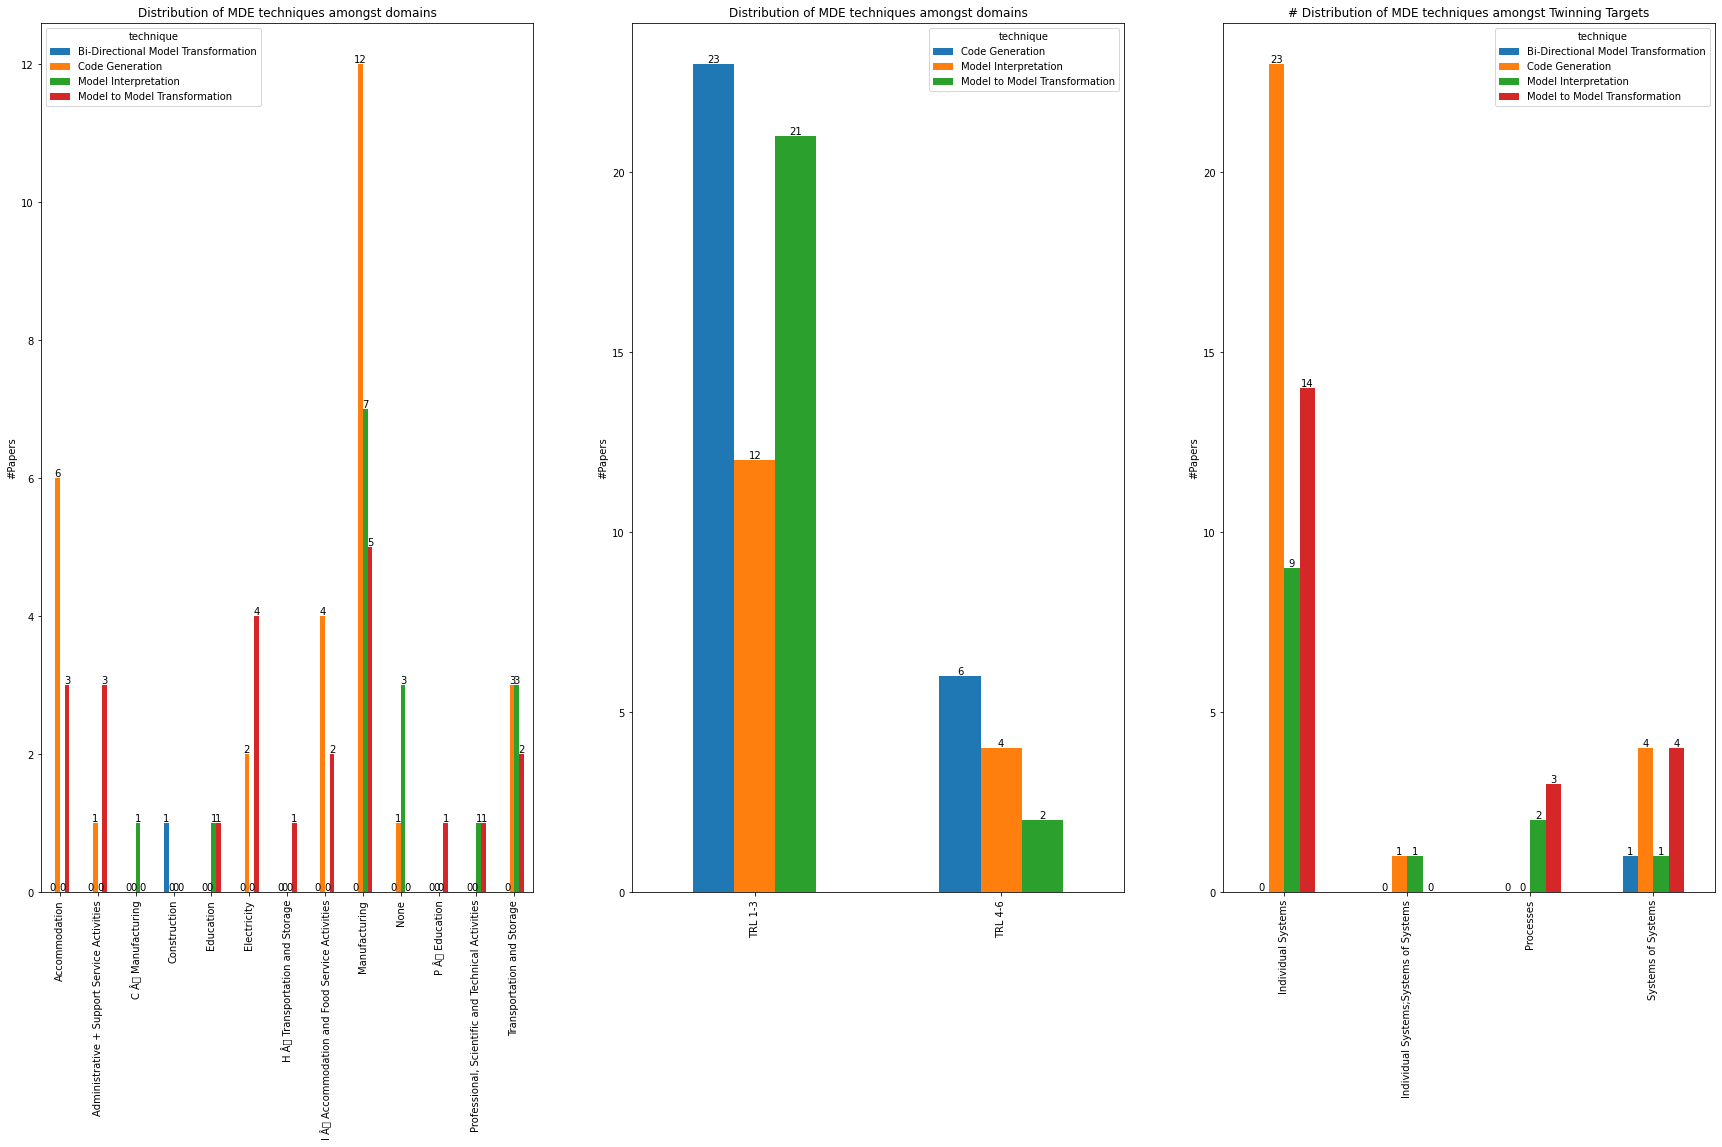

In [7]:
domains_techniques = pd.DataFrame(columns = ['value', 'technique'])
system_lcp_techniques = pd.DataFrame(columns = ['value', 'technique'])
twin_lcp_techniques = pd.DataFrame(columns = ['value', 'technique'])
twinning_target_techniques = pd.DataFrame(columns = ['value', 'technique'])
trl_techniques = pd.DataFrame(columns = ['value', 'technique'])

with open("target/json/data_consolidated_semistructured.json", 'r') as json_file:
    data_semistr = json.load(json_file)
    
mde_techniques = data["model processing technique"].value_counts().index.tolist()
for title, contents in data_semistr.items():
    domain = contents["use case domain"]
    trl = contents["Technological Readiness Level"]
    twinning_target = contents["twinning target"]
    for index, mdeContents in contents["modelTrafos"].items():
        mdeContents = json.loads(mdeContents)
        new_line = pd.DataFrame([{"value": domain, "technique": mdeContents["model processing technique"]}])
        domains_techniques = pd.concat([domains_techniques, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"value": trl, "technique": mdeContents["model processing technique"]}])
        trl_techniques = pd.concat([trl_techniques, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"value": twinning_target, "technique": mdeContents["model processing technique"]}])
        twinning_target_techniques = pd.concat([twinning_target_techniques, new_line], ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 16))
ax = domains_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[0], 
                                                                             ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
label_pre = 0
for container in ax.containers:
    ax.bar_label(container)

ax = trl_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[1],
                                                                         ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
plt.title('# Distribution of MDE techniques amongst Technological Readiness Levels')
for container in ax.containers:
    ax.bar_label(container)
ax = twinning_target_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[2],
                                                                                     ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
for container in ax.containers:
    ax.bar_label(container)
plt.title('# Distribution of MDE techniques amongst Twinning Targets')
plt.savefig("where_detailed.jpg")